In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
from scipy.stats import permutation_test
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pd.options.mode.chained_assignment = None
sns.set_style('dark')

In [165]:
df = pd.read_parquet('parquet/us_full_covid.parquet')
df_eur = pd.read_parquet('parquet/eur_full_covid.parquet')
df_can = pd.read_parquet('parquet/can-covid-mar2020-apr2022.parquet')

df['prediction'] = np.where(df['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.
df_eur['prediction'] = np.where(df_eur['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.
df_can['prediction'] = np.where(df_can['prediction'] == 0, -1, 1) # More intuitive sentiment score scales.

political_ideology = (pd.read_csv('top_30_publishers_annotate.csv')
                    .rename(columns={'Unnamed: 0': 'publisher', 'publisher': 'drop_this'})
                    .drop(columns=['drop_this', 'nuanced']))
df = df.merge(political_ideology, on='publisher', how='outer')

## Basic Data Summary

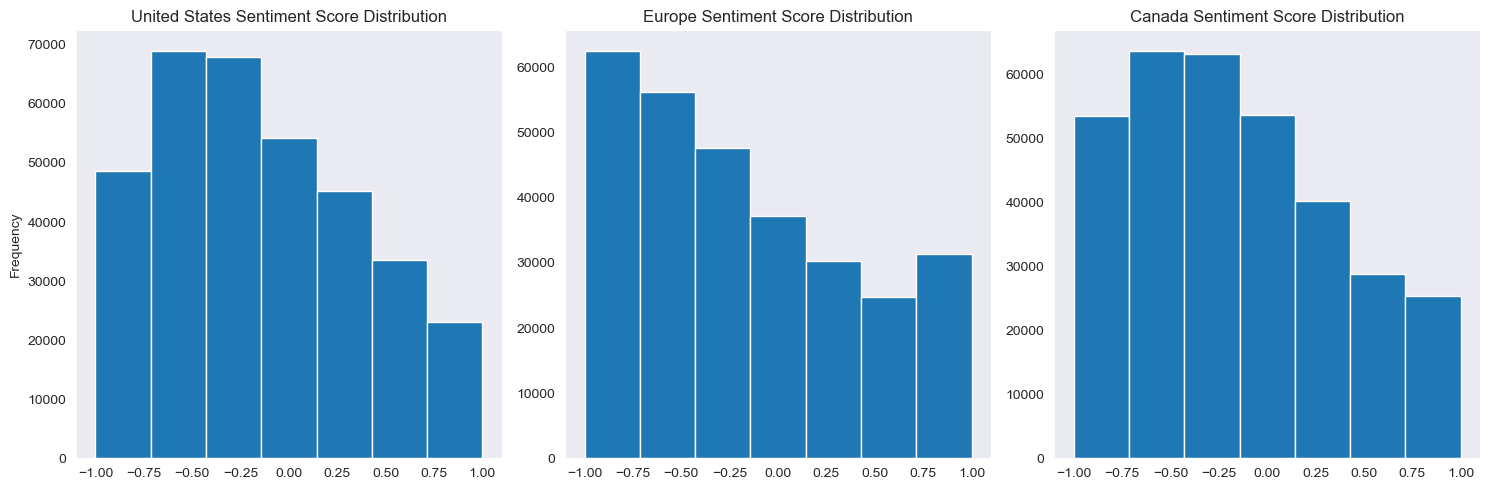

In [166]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
df.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[0])
df_eur.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[1])
df_can.groupby('article_id')['prediction'].mean().plot.hist(bins=7, ax=axs[2])
axs[0].set_title("United States Sentiment Score Distribution")
axs[1].set_title("Europe Sentiment Score Distribution")
axs[1].set_ylabel("")
axs[2].set_title("Canada Sentiment Score Distribution")
axs[2].set_ylabel("")
plt.tight_layout()

In [167]:
summary_df = pd.DataFrame({'Article Sample Size':[df['article_id'].nunique() ,df_can['article_id'].nunique(), df_eur['article_id'].nunique()],
            'Average Sentiment Score': [df['prediction'].mean() ,df_can['prediction'].mean(), df_eur['prediction'].mean()]},
            index=['United States', 'Canada', 'Europe'])
summary_df

,Article Sample Size,Average Sentiment Score
United States,341637,-0.165165
Canada,328768,-0.178574
Europe,290174,-0.204162


In [168]:
def get_sample_per_predict_block(dataframe):
    predict_block_per = []
    for predict_blocks in range(1,7):
        percent_articles_w_block = round(100 * np.sum(dataframe['article_id'].value_counts() == predict_blocks) / dataframe['article_id'].nunique(), 2)
        predict_block_per.append(percent_articles_w_block)
    return predict_block_per

us_predict_block_per = get_sample_per_predict_block(df)
eur_predict_block_per = get_sample_per_predict_block(df_eur)
can_predict_block_per = get_sample_per_predict_block(df_can)

sample_length_per_article = pd.DataFrame({'US percent sample per block':us_predict_block_per,}, index=np.arange(1,7))
sample_length_per_article['Europe percent sample per block'] = eur_predict_block_per
sample_length_per_article['Canada percent sample per block'] = can_predict_block_per

sample_length_per_article

,US percent sample per block,Europe percent sample per block,Canada percent sample per block
1,0.19,1.48,1.02
2,1.21,6.19,4.52
3,2.96,8.44,6.23
4,4.32,10.04,7.91
5,8.10,11.59,11.55
6,83.22,62.26,68.78


Ideally we would want most articles to have at least 5 prediction blocks since that would mean there were over 15 sentences to run the analysis on. Anything below 3 is suspect but accounts for only 1.5% of the data.

## Sentiment Score per Prediction Block (each block contains around 3 sentences)

In [169]:
def get_sentiment_per_block(dataframe):
    avg_sentiment_per_block = []
    for predict_blocks in range(0,6):
        sentiment_per_block = dataframe.groupby('article_id').nth(predict_blocks)['prediction'].mean()
        avg_sentiment_per_block.append(sentiment_per_block)
    return avg_sentiment_per_block

us_avg_sentiment_per_block = get_sentiment_per_block(df) 
eur_avg_sentiment_per_block = get_sentiment_per_block(df_eur) 
can_avg_sentiment_per_block = get_sentiment_per_block(df_can) 

avg_sentiment_per_block_df = pd.DataFrame({'US Average Sentiment':us_avg_sentiment_per_block,}, index=np.arange(1,7))
avg_sentiment_per_block_df['Europe Average Sentiment'] = eur_avg_sentiment_per_block
avg_sentiment_per_block_df['Canada Average Sentiment'] = can_avg_sentiment_per_block
avg_sentiment_per_block_df.index = ['Sentences 1-3', 'Sentences 4-7', 'Sentences 8-10', 'Sentences 11-14', 'Sentences 15-18', 'Last three Sentences']
avg_sentiment_per_block_df.round(3)

,US Average Sentiment,Europe Average Sentiment,Canada Average Sentiment
Sentences 1-3,-0.247,-0.305,-0.258
Sentences 4-7,-0.218,-0.242,-0.193
Sentences 8-10,-0.204,-0.199,-0.208
Sentences 11-14,-0.181,-0.184,-0.188
Sentences 15-18,-0.163,-0.182,-0.148
Last three Sentences,0.058,-0.043,-0.027


RoBERTa can only take in 500 characters at a time, so to predict the sentiment for an article it needs to be split into chunks. Based on previous literature the best way to do so was to allow for as many sentences as possible for a single prediction.
This turned out to be around 3 sentences per prediction and I did this 6 times for each article (hence 6 blocks of predictions). What this table shows is quite clear: The first 3 sentences are the most negative, followed by the next three sentences, followed by the next three and so on in a monotonically decreasing fashion. This makes sense from the demand side of view of publishers since they must "capture" their audience within the first parts of the article to keep the readers attention. By the last 3 sentences, the articles are about neutral in sentiment.

A very robust finding across all three countries with the slight exception of Canada for its senteces between 4-7 and 8-11. 

<AxesSubplot:>

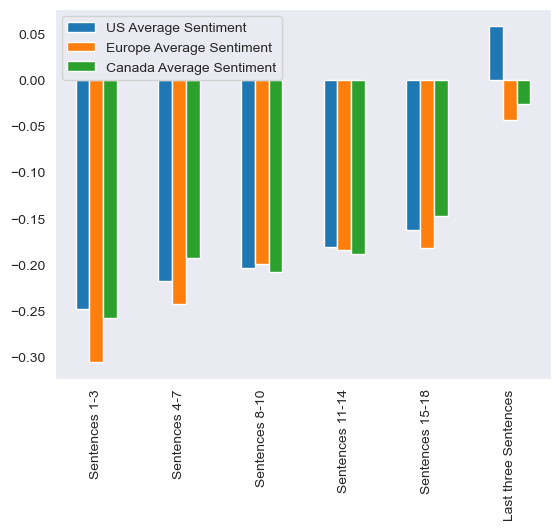

In [170]:
avg_sentiment_per_block_df.plot.bar()

## Page Number Analysis

In [171]:
def get_page_avg_sentiment(dataframe, country, top_n_page_samples=15):
    page_num_avg_sentiment = dataframe.groupby('page_num', as_index=False)['prediction'].mean()
    page_num_avg_sentiment_df = page_num_avg_sentiment[page_num_avg_sentiment['page_num'].isin(dataframe['page_num'].value_counts()[:top_n_page_samples].index)]
    page_num_avg_sentiment_df = page_num_avg_sentiment_df.rename(columns={'page_num':f"{country} page_num", 'prediction':f"{country} prediction"}).reset_index(drop=True)
    return page_num_avg_sentiment_df

In [172]:
avg_page_df_us = get_page_avg_sentiment(df, 'US')
avg_page_df_can = get_page_avg_sentiment(df_can, 'Canada')
avg_page_df_eur = get_page_avg_sentiment(df_eur, 'Europe')
avg_page_df = pd.concat([avg_page_df_us, avg_page_df_can, avg_page_df_eur],axis=1)
avg_page_df.round(2)

,US page_num,US prediction,Canada page_num,Canada prediction,Europe page_num,Europe prediction
0,1,-0.13,A.1,-0.15,1,-0.28
1,A.1,-0.19,A.10,-0.17,10,-0.17
2,A.2,-0.13,A.11,-0.16,12,-0.16
3,A.3,-0.13,A.2,-0.10,13,-0.21
4,A.4,-0.16,A.3,-0.13,14,-0.17
5,A.5,-0.14,A.4,-0.23,2,-0.19
6,A.6,-0.15,A.5,-0.16,3,-0.13
7,A.7,-0.18,A.6,-0.20,4,-0.21
8,A.8,-0.19,A.7,-0.18,5,-0.19
9,A.9,-0.18,A.8,-0.18,6,-0.21


In [173]:
agg_dict = {'publisher': 'first', 'page_num':'first', 'political_ideology':'first', 'country':'first','prediction':'mean'}
df['country'] = "us"
df_can['country'] = "can"
df_eur['country'] = "eur"
full_df = pd.concat([df,df_can,df_eur],axis=0, ignore_index=True)
full_df = full_df.groupby(['date','article_id'],as_index=False).agg(agg_dict)
df_eur = full_df.query('country == "eur" ').copy()
df_can = full_df.query('country == "can" ').copy()
df = full_df.query('country == "us" ').copy()

avg_page_df_us = get_page_avg_sentiment(df, 'US')
avg_page_df_can = get_page_avg_sentiment(df_can, 'Canada')
avg_page_df_eur = get_page_avg_sentiment(df_eur, 'Europe')
avg_page_df = pd.concat([avg_page_df_us, avg_page_df_can, avg_page_df_eur],axis=1)
avg_page_df.round(2)

,US page_num,US prediction,Canada page_num,Canada prediction,Europe page_num,Europe prediction
0,1,-0.13,A.1,-0.15,1,-0.30
1,A.1,-0.19,A.10,-0.17,10,-0.16
2,A.2,-0.13,A.11,-0.16,12,-0.15
3,A.3,-0.14,A.2,-0.10,13,-0.20
4,A.4,-0.16,A.3,-0.12,14,-0.17
5,A.5,-0.14,A.4,-0.22,2,-0.19
6,A.6,-0.16,A.5,-0.16,3,-0.12
7,A.7,-0.18,A.6,-0.20,4,-0.20
8,A.8,-0.19,A.7,-0.17,5,-0.18
9,A.9,-0.19,A.8,-0.18,6,-0.20


I should sort these based on relevant page numbers so Nona and n/a aren't included.

But in general there isn't a strong pattern with the exception of page 1 and page 2-3 having a clear monotonic increase in average sentiment score. I am not sure how the A page numbering works for newspapers and I'm not entirely convinced by the low sample size variance biasing the results here.

I think I should try a **permutation test** because this seems like the exact case where the null distribution has a ton of noise. 

## Articles Published per Day

In [174]:
# us_articles_published_per_day = (df.rename(columns={'article_id': 'Articles Published per Day'})
#                                 .groupby('date')['Articles Published per Day'].nunique()
#                                 .rolling(window=4, center=True, win_type='gaussian').mean(std=2))
# eur_articles_published_per_day = (df_eur.rename(columns={'article_id': 'Articles Published per Day'})
#                                 .groupby('date')['Articles Published per Day'].nunique()
#                                 .rolling(window=4, center=True, win_type='gaussian').mean(std=2))
# can_articles_published_per_day = (df_can.rename(columns={'article_id': 'Articles Published per Day'})
#                                 .groupby('date')['Articles Published per Day'].nunique()
#                                 .rolling(window=5, center=True, win_type='gaussian').mean(std=2))

front_page_df = full_df.query('page_num == "1" or page_num == "A.1"')

health_data_df = pd.read_parquet('parquet/cleaned_health_data.parquet')
us_front_page_df = front_page_df.query("country == 'us'")
can_front_page_df = front_page_df.query("country == 'can'")
eur_front_page_df = front_page_df.query("country == 'eur'")

us_front_page_df = us_front_page_df.merge(health_data_df.loc['United States', ['date','positive_rate']], on='date', how='inner')
can_front_page_df = can_front_page_df.merge(health_data_df.loc['Canada', ['date','positive_rate']], on='date', how='inner')
eur_front_page_df = eur_front_page_df.merge(health_data_df.loc['United Kingdom', ['date','positive_rate']], on='date', how='inner')

us_front_page_df = us_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})
can_front_page_df = can_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})
eur_front_page_df = eur_front_page_df.groupby('date').agg({'article_id':'nunique', 'positive_rate':'first', 'country':'first'}).rename(columns={'article_id':'Articles Published per Day', 'positive_rate':'Covid Positive Rate'})

us_front_page_df['Articles Published per Day'] = us_front_page_df['Articles Published per Day'].rolling(3, center=True, win_type='gaussian').mean(std=1)
can_front_page_df['Articles Published per Day'] = can_front_page_df['Articles Published per Day'].rolling(4, center=True, win_type='gaussian').mean(std=1)
eur_front_page_df['Articles Published per Day'] = eur_front_page_df['Articles Published per Day'].rolling(4, center=True, win_type='gaussian').mean(std=1)

In [175]:
front_page_df = pd.concat([us_front_page_df, can_front_page_df, eur_front_page_df]).groupby(['country', 'date']).first().reset_index(level=1)
front_page_df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/front_page_df.parquet')

<AxesSubplot:xlabel='date'>

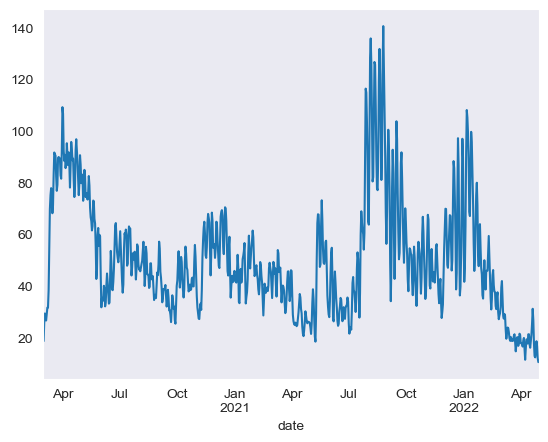

In [176]:
us_front_page_stories = df.query('page_num == "1" or page_num == "A.1"')
# us_front_page_stories.groupby('date')['article_id'].nunique().plot()
us_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()

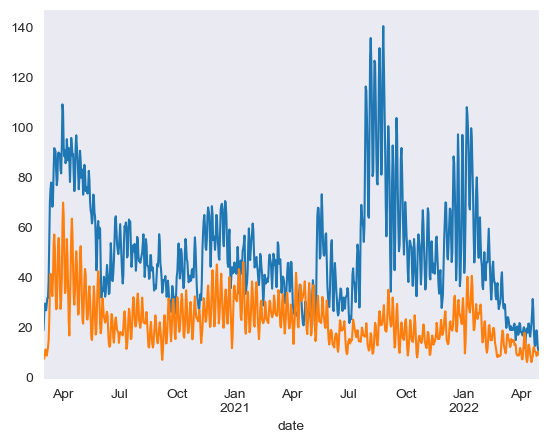

In [177]:
us_front_page_stories = df.query('page_num == "1" or page_num == "A.1"')
# us_front_page_stories.groupby('date')['article_id'].nunique().plot()
us_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()
# us_front_page_stories = df.query('page_num == "A.1"')

can_front_page_stories = df_can.query('page_num == "A.1"')
can_front_page_stories.groupby('date')['article_id'].nunique().rolling(4, center=True, win_type='gaussian').mean(std=2).plot()

eur_front_page_stories = df_eur.query('page_num == "1"')
# eur_front_page_stories.groupby('date')['article_id'].nunique().plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=2).plot()
# eur_front_page_stories.groupby('date')['article_id'].nunique().rolling(3, center=True, win_type='gaussian').mean(std=1).plot()

# notfront_page_stories = df.query('(page_num != "None") and (page_num != "n/a")')
# (front_page_stories.groupby('date')['article_id'].nunique() / notfront_page_stories.groupby('date')['article_id'].nunique()).plot()

<AxesSubplot:xlabel='date'>

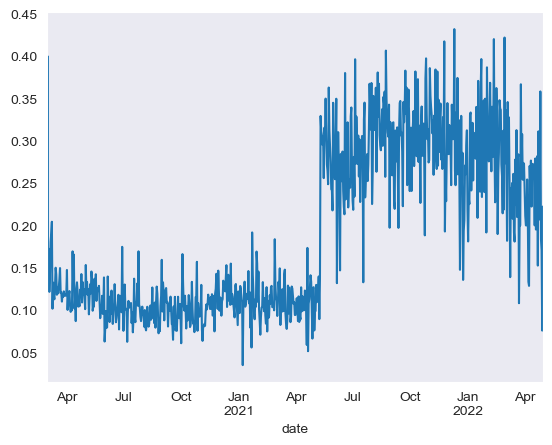

In [178]:
us_front_page_stories = df.query('page_num == "A.1"')
notfront_page_stories = df.query('(page_num != "None") and (page_num != "n/a")')
(us_front_page_stories.groupby('date')['article_id'].nunique() / notfront_page_stories.groupby('date')['article_id'].nunique()).plot()

It appears that ProQuest has a change in scraping around april where the majority of articles are front page articles. Not sure why this happens. I could supplement this story by just checking headlines and how often a headline mentions "Covid".

## Sentiment Analysis by Political Affiliation

In [179]:
us_political_df = df.dropna(subset='political_ideology')
df.groupby('political_ideology')['prediction'].mean()

political_ideology
C   -0.154393
L   -0.228938
R   -0.130079
Name: prediction, dtype: float64

<AxesSubplot:xlabel='date'>

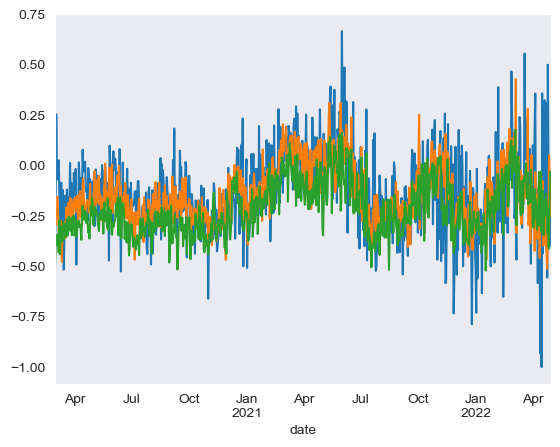

In [183]:
us_political_df.query('political_ideology == "R"').groupby('date')['prediction'].mean().plot()
us_political_df.query('political_ideology == "C"').groupby('date')['prediction'].mean().plot()
us_political_df.query('political_ideology == "L"').groupby('date')['prediction'].mean().plot()
# plt.legend()

In [184]:
us_political_df = us_political_df.groupby(['political_ideology', 'date'])['prediction'].mean().reset_index(level=1)
us_political_df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/us_political_sentiment.parquet')

In [185]:
# us_political_df.loc['R', 'prediction']
us_political_df.loc['R', 'date']

political_ideology
R   2020-03-01
R   2020-03-02
R   2020-03-03
R   2020-03-04
R   2020-03-05
       ...    
R   2022-04-26
R   2022-04-27
R   2022-04-28
R   2022-04-29
R   2022-04-30
Name: date, Length: 791, dtype: datetime64[ns]

In [163]:
smoothed_c = us_political_df.loc['C']['prediction'].rolling(3,center=True).mean()
smoothed_r = us_political_df.loc['R']['prediction'].rolling(3,center=True).mean()
smoothed_l = us_political_df.loc['L']['prediction'].rolling(3,center=True).mean()

smoothed_pred = pd.concat([smoothed_c, smoothed_r, smoothed_l]).reset_index(drop=True)

# pd.concat([us_political_df, smoothed_pred], axis=1)

In [121]:
us_political_df['smoothed_pred'] = smoothed_pred

In [108]:
us_political_df.join(smoothed_pred,rsuffix='_smoothed')

,date,prediction,prediction_smoothed
political_ideology,,,
C,2020-03-01,-0.152778,NaN
C,2020-03-01,-0.152778,-0.226587
C,2020-03-01,-0.152778,-0.227123
C,2020-03-01,-0.152778,-0.184537
C,2020-03-01,-0.152778,-0.190211
...,...,...,...
R,2022-04-30,-0.200000,0.134921
R,2022-04-30,-0.200000,-0.165079
R,2022-04-30,-0.200000,-0.178151


In [257]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_political_df.loc['R', 'date'], y=us_political_df.loc['R', 'prediction'], name='Republican', line={'color':'#fc2626'}, opacity=0.9))
fig.add_trace(go.Scatter(x=us_political_df.loc['L', 'date'], y=us_political_df.loc['L', 'prediction'], name='Liberal', line={'color':'#585fcc'}, opacity=0.9))
fig.add_trace(go.Scatter(x=us_political_df.loc['C', 'date'], y=us_political_df.loc['C', 'prediction'], name='Moderate',))
fig.update_yaxes(title_text="Sentiment Score")

## Sentiment Score Graphs

In [231]:
df = df.groupby('date', as_index=False).agg(agg_dict)
df_eur = df_eur.groupby('date', as_index=False).agg(agg_dict)
df_can = df_can.groupby('date', as_index=False).agg(agg_dict)

df['smoothed_prediction'] = df.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)
df_eur['smoothed_prediction'] = df_eur.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)
df_can['smoothed_prediction'] = df_can.prediction.rolling(window=3, center=True, win_type="gaussian").mean(std=1)

health_data_df = pd.read_parquet('parquet/cleaned_health_data.parquet')

df = df.merge(health_data_df.loc['United States'], on='date', how='inner')
df_can = df_can.merge(health_data_df.loc['Canada'], on='date', how='inner')
df_eur = df_eur.merge(health_data_df.loc['United Kingdom'], on='date', how='inner')

In [37]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df['date'], y=df['smoothed_prediction'], name="Sentiment Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df['date'], y=df['positive_rate'], name="Covid Positive Rate"),
    secondary_y=True, 
)


In [38]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_can['date'], y=df_can['smoothed_prediction'], name="Sentiment Score"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_can['date'], y=df_can['positive_rate'], name="Covid Positive Rate"),
    secondary_y=True, 
)


In [39]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df["date"], y=df["prediction"], name="US", mode="lines"))
# fig.add_trace(go.Scatter(x=df_can["date"], y=df_can["prediction"], name="Can", mode="lines"))
# fig.add_trace(go.Scatter(x=df_eur["date"], y=df_eur["prediction"], name="eur", mode="lines"))

# # fig.update_layout(
# #     title="ICICI BANK stock prices", xaxis_title="Date", yaxis_title="Close"
# # )

# Other

In [40]:
df = df.merge(us_articles_published_per_day, on='date')
df_eur = df_eur.merge(eur_articles_published_per_day, on='date')
df_can = df_can.merge(can_articles_published_per_day, on='date')

df = df.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})
df_eur = df_eur.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})
df_can = df_can.rename(columns={'positive_rate': 'Covid Positive Rate', 'smoothed_prediction':'Sentiment Score'})

df.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/us_covid_dash.parquet')
df_eur.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/eur_covid_dash.parquet')
df_can.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/can_covid_dash.parquet')